<a href="https://colab.research.google.com/github/Konic-NLP/5922-deep-learning/blob/main/lab_assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# get the dataset IMDB review
import tensorflow.keras as keras
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words= 10000)

17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
import numpy as np
y_train=np.array(y_train)
y_test=np.array(y_test)

In [ ]:
# view the distribution of the class - it's a balanced dataset
from collections import Counter
counter=Counter
print(counter(y_train))
print(counter(y_test))

Counter({1: 12500, 0: 12500})
Counter({0: 12500, 1: 12500})


In [ ]:
# view the shape, it's a dataset with 25000 samples for train and 25000 for test
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(25000,) (25000,) (25000,) (25000,)


In [ ]:
# sorted the testset based on the word length of the input
Y=zip(x_test,y_test)
Y=sorted(Y,key=lambda x:len(x[0]))
x_test_sorted,y_test_sorted=zip(*Y)

In [ ]:
# get the size for each bucket
print(int(25000/3))

8333


In [ ]:
# split the sorted testset based on the size of the bucket 
x_test_short,y_test_short=x_test_sorted[:8333],y_test_sorted[:8333]
x_test_medium,y_test_medium=x_test_sorted[8333:2*8333],y_test_sorted[8333:2*8333]
x_test_long,y_test_long=x_test_sorted[2*8333:],y_test_sorted[2*8333:]

In [ ]:
# view the range for each group 
print(len(x_test_short[0]),len(x_test_short[-1]),len(x_test_medium[0]),len(x_test_medium[-1]),len(x_test_long[0]),len(x_test_long[-1]))

7 140 140 230 230 2315


In [ ]:
#vefified
print(len(x_test_short),len(x_test_medium),len(x_test_long))
print(x_test_short[:3])

8333 8333 8334
([1, 332, 4, 274, 859, 4, 20], [1, 4101, 114, 4101, 458, 338, 2956], [1, 53, 2570, 53, 1302, 76, 76, 53, 1193])


In [ ]:
# view the mean and median which is useful for decided the max length for padding
import numpy as np
print(sorted(list(map(len,x_train)),reverse=True)[:10],sorted(list(map(len,x_test)),reverse=True)[:10])
print(np.mean(list(map(len,x_train))),sorted(list(map(len,x_train)),reverse=True)[len(x_train)//2])
print(np.mean(list(map(len,x_test))),sorted(list(map(len,x_test)),reverse=True)[len(x_test)//2])

[2494, 1854, 1851, 1733, 1629, 1571, 1546, 1530, 1409, 1403] [2315, 2119, 2110, 1700, 1375, 1162, 1158, 1095, 1093, 1084]
238.71364 178
230.8042 174


In [ ]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=500)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=500)


build the network 

In [ ]:
# the embedding layer
from keras.layers import Embedding
from keras.initializers import Constant

embedding_layer = Embedding(10000, 300,
                                                    trainable=True
)

In [ ]:
## 1. Create a simple Bidirectional LSTM model

from keras import layers, Input, Model,Sequential

int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(layers.LSTM(20, return_sequences=True))(embedded_sequences)
x = layers.Bidirectional(layers.LSTM(20))(x)
preds = layers.Dense(1, activation="sigmoid")(x)
model = Model(int_sequences_input, preds)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 300)         3000000   
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 40)         51360     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 41        
                                                                 
Total params: 3,061,161
Trainable params: 3,061,161
Non-tra

In [ ]:
# just saved for best model 
from keras.callbacks import ModelCheckpoint
filepath="weights-GRU_Glove_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,
mode='max')
callbacks_list = [checkpoint]

In [ ]:
# define a function to compute the F,P,R with scikit-learn
from sklearn.metrics import recall_score,precision_score,f1_score
def p_r_score(y_true,y_predict):
  y_test_short=np.array(y_true)
  print("precision: %.3f "%precision_score(y_true,[1 if x>0.5 else 0 for x in y_predict]))
  print("recall: %.3f"%recall_score(y_true,[1 if x>0.5 else 0 for x in y_predict]))
  print("F1 :%.3f"%f1_score(y_true,[1 if x>0.5 else 0 for x in y_predict]))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train,y_train,batch_size=512,
          epochs=10,
          validation_data=(x_test,y_test),callbacks=callbacks_list)
# score, acc = model.evaluate(x_test, y_test,
#                             batch_size=512)
probabilities=model.predict(x_test,batch_size=512)
p_r_score(y_test,probabilities)

Train...
Epoch 1/10
49/49 [==============================] - ETA: 0s - loss: 0.4885 - accuracy: 0.8156
Epoch 1: val_accuracy improved from -inf to 0.81188, saving model to weights-newbest.hdf5
49/49 [==============================] - 39s 645ms/step - loss: 0.4885 - accuracy: 0.8156 - val_loss: 0.4487 - val_accuracy: 0.8119
Epoch 2/10
49/49 [==============================] - ETA: 0s - loss: 0.3178 - accuracy: 0.8831
Epoch 2: val_accuracy improved from 0.81188 to 0.82600, saving model to weights-newbest.hdf5
49/49 [==============================] - 30s 606ms/step - loss: 0.3178 - accuracy: 0.8831 - val_loss: 0.4793 - val_accuracy: 0.8260
Epoch 3/10
49/49 [==============================] - ETA: 0s - loss: 0.2477 - accuracy: 0.9162
Epoch 3: val_accuracy improved from 0.82600 to 0.84216, saving model to weights-newbest.hdf5
49/49 [==============================] - 29s 603ms/step - loss: 0.2477 - accuracy: 0.9162 - val_loss: 0.4227 - val_accuracy: 0.8422
Epoch 4/10
49/49 [===================

In [ ]:
# calculate the result predicted on 'short' set
short= keras.preprocessing.sequence.pad_sequences(x_test_short, maxlen=500)
short=model.predict(short,batch_size=512)
p_r_score(y_test_short,short)


precision: 0.845 
recall: 0.895
F1 :0.869


In [ ]:
#calculate the medium length set
medium= keras.preprocessing.sequence.pad_sequences(x_test_medium, maxlen=500)
medium=model.predict(medium,batch_size=512)
p_r_score(y_test_medium,medium)


precision: 0.809 
recall: 0.890
F1 :0.847


In [ ]:
# calculate the long lenth set
long= keras.preprocessing.sequence.pad_sequences(x_test_long, maxlen=500)
long=model.predict(long,batch_size=512)
p_r_score(y_test_long,long)


precision: 0.796 
recall: 0.867
F1 :0.830


2.same model but with vanilla RNN

In [ ]:
from keras import layers, Input, Model,Sequential

int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(layers.SimpleRNN(20, return_sequences=True))(embedded_sequences)
x = layers.Bidirectional(layers.SimpleRNN(20))(x)
preds = layers.Dense(1, activation="sigmoid")(x)
RNNmodel = Model(int_sequences_input, preds)
RNNmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         3000000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 40)         12840     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               2440      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 3,015,321
Trainable params: 3,015,321
Non-train

In [ ]:
RNNmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
RNNmodel.fit(x_train,y_train,batch_size=512,
          epochs=10,
          validation_data=(x_test,y_test),callbacks=callbacks_list)
result=RNNmodel.predict(x_test,batch_size=512,verbose=1)
p_r_score(y_test,result)

Train...
Epoch 1/10
49/49 [==============================] - ETA: 0s - loss: 0.3498 - accuracy: 0.8752
Epoch 1: val_accuracy improved from -inf to 0.83060, saving model to weights-RNNnewbest.hdf5
49/49 [==============================] - 165s 3s/step - loss: 0.3498 - accuracy: 0.8752 - val_loss: 0.4471 - val_accuracy: 0.8306
Epoch 2/10
49/49 [==============================] - ETA: 0s - loss: 0.3262 - accuracy: 0.8762
Epoch 2: val_accuracy did not improve from 0.83060
49/49 [==============================] - 160s 3s/step - loss: 0.3262 - accuracy: 0.8762 - val_loss: 0.5099 - val_accuracy: 0.7834
Epoch 3/10
49/49 [==============================] - ETA: 0s - loss: 0.2790 - accuracy: 0.8980
Epoch 3: val_accuracy did not improve from 0.83060
49/49 [==============================] - 161s 3s/step - loss: 0.2790 - accuracy: 0.8980 - val_loss: 0.4804 - val_accuracy: 0.8130
Epoch 4/10
49/49 [==============================] - ETA: 0s - loss: 0.2552 - accuracy: 0.9020
Epoch 4: val_accuracy did not 

In [ ]:
x_test_short=keras.preprocessing.sequence.pad_sequences(x_test_short,maxlen=500)
short=RNNmodel.predict(x_test_short,batch_size=512)
p_r_score(y_test_short,short)

precision: 0.668 
recall: 0.904
F1 :0.768


In [ ]:
x_test_medium=keras.preprocessing.sequence.pad_sequences(x_test_medium,maxlen=500)
medium=RNNmodel.predict(x_test_medium,batch_size=512)
p_r_score(y_test_medium,medium)

precision: 0.624 
recall: 0.897
F1 :0.736


In [ ]:
x_test_long=keras.preprocessing.sequence.pad_sequences(x_test_long,maxlen=500)
long=RNNmodel.predict(x_test_long,batch_size=512)
p_r_score(y_test_long,long)

precision: 0.609 
recall: 0.897
F1 :0.726


In [ ]:
# 3. the model with GRU
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(layers.GRU(20, return_sequences=True))(embedded_sequences)
x = layers.Bidirectional(layers.GRU(20))(x)
preds = layers.Dense(1, activation="sigmoid")(x)
GRUmodel = Model(int_sequences_input, preds)
GRUmodel.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 300)         3000000   
                                                                 
 bidirectional_10 (Bidirecti  (None, None, 40)         38640     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 40)               7440      
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 1)                 41        
                                                                 
Total params: 3,046,121
Trainable params: 3,046,121
Non-tra

In [ ]:
GRUmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
GRUmodel.fit(x_train,y_train,batch_size=512,
          epochs=10,
          validation_data=(x_test,y_test),callbacks=callbacks_list)
result=GRUmodel.predict(x_test,512)
p_r_score(y_test,result)

Train...
Epoch 1/10
49/49 [==============================] - ETA: 0s - loss: 0.5328 - accuracy: 0.7375
Epoch 1: val_accuracy improved from -inf to 0.75360, saving model to weights-GRUnewbest.hdf5
49/49 [==============================] - 36s 594ms/step - loss: 0.5328 - accuracy: 0.7375 - val_loss: 0.5234 - val_accuracy: 0.7536
Epoch 2/10
49/49 [==============================] - ETA: 0s - loss: 0.2381 - accuracy: 0.9052
Epoch 2: val_accuracy improved from 0.75360 to 0.85240, saving model to weights-GRUnewbest.hdf5
49/49 [==============================] - 27s 562ms/step - loss: 0.2381 - accuracy: 0.9052 - val_loss: 0.4193 - val_accuracy: 0.8524
Epoch 3/10
49/49 [==============================] - ETA: 0s - loss: 0.0950 - accuracy: 0.9713
Epoch 3: val_accuracy did not improve from 0.85240
49/49 [==============================] - 27s 560ms/step - loss: 0.0950 - accuracy: 0.9713 - val_loss: 0.5498 - val_accuracy: 0.8340
Epoch 4/10
49/49 [==============================] - ETA: 0s - loss: 0.066

In [ ]:
short=GRUmodel.predict(x_test_short,batch_size=512)
p_r_score(y_test_short,short)


precision: 0.880 
recall: 0.847
F1 :0.863


In [ ]:
medium=GRUmodel.predict(x_test_medium,512)
p_r_score(y_test_medium,medium)

precision: 0.856 
recall: 0.825
F1 :0.840


In [ ]:
long=GRUmodel.predict(x_test_long,512)
p_r_score(y_test_long,long)

precision: 0.853 
recall: 0.791
F1 :0.821


In [ ]:
# download the glove embedding 
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-03-06 19:25:59--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-06 19:25:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-06 19:25:59--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
#define a function to draw the confusion matrix with matplotlib
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
def show_confusion_matrix(y_true,y_pred,title):
  y_pred=[1 if x>=0.5 else 0 for x  in y_pred ]
  mat=confusion_matrix(y_true,y_pred)
  print(mat)
  sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False)
  plt.title(title)
  plt.xlabel("True Label")
  plt.ylabel("Predicted Label")

read the glove emebeddings 

In [ ]:
import os
path_to_glove_file = "glove.6B.300d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# read the glove emebddings into a dict <word,embeddings>
word_index=keras.datasets.imdb.get_word_index()
num=0
voc=dict()
for k,v in  sorted(word_index.items(),key=lambda x :x[1])[:10000]:
  voc[k]=v
## Create "embedding_matrix" to index our vocabulary using the GloVe model 
num_tokens = len(voc) 
embedding_dim = 300 ##  dimensions
hits = 0 ## number of words that were found in the pretrained model
misses = 0 ## number of words that were missing in the pretrained model

# Prepare embedding matrix for our word list
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in voc.items():
    embedding_vector = embeddings_index.get(word.lower())
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i-1] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

  # if num==10:
  #   break

1654784/1641221 [==============================] - 0s 0us/step
Converted 9797 words (203 misses)


In [ ]:
# 1.fine-tuning the glove
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
embedding_layer = Embedding(num_tokens, embedding_dim,
                            embeddings_initializer= Constant(embedding_matrix), 
                            trainable=True,
)

In [ ]:
# train with bidirectional GRU
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(layers.GRU(20, return_sequences=True))(embedded_sequences)
x = layers.Bidirectional(layers.GRU(20))(x)
preds = layers.Dense(1, activation="sigmoid")(x)
GRUmodel = Model(int_sequences_input, preds)
GRUmodel.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 300)         3000000   
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 40)         38640     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 40)               7440      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 41        
                                                                 
Total params: 3,046,121
Trainable params: 3,046,121
Non-tra

Train...
Epoch 1/10
49/49 [==============================] - ETA: 0s - loss: 0.6757 - accuracy: 0.5642
Epoch 1: val_accuracy improved from -inf to 0.64424, saving model to weights-best_glove.hdf5
49/49 [==============================] - 49s 878ms/step - loss: 0.6757 - accuracy: 0.5642 - val_loss: 0.6359 - val_accuracy: 0.6442
Epoch 2/10
49/49 [==============================] - ETA: 0s - loss: 0.5139 - accuracy: 0.7457
Epoch 2: val_accuracy improved from 0.64424 to 0.81560, saving model to weights-best_glove.hdf5
49/49 [==============================] - 41s 850ms/step - loss: 0.5139 - accuracy: 0.7457 - val_loss: 0.4168 - val_accuracy: 0.8156
Epoch 3/10
49/49 [==============================] - ETA: 0s - loss: 0.3165 - accuracy: 0.8690
Epoch 3: val_accuracy improved from 0.81560 to 0.85300, saving model to weights-best_glove.hdf5
49/49 [==============================] - 41s 852ms/step - loss: 0.3165 - accuracy: 0.8690 - val_loss: 0.3541 - val_accuracy: 0.8530
Epoch 4/10
49/49 [==========

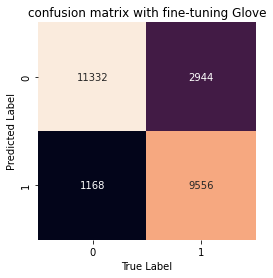

In [ ]:
from keras.callbacks import ModelCheckpoint
GRUmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
filepath="weights-best_glove.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,
mode='max')
callbacks_list = [checkpoint]
GRUmodel.fit(x_train,y_train,batch_size=512,
          epochs=10,
          validation_data=(x_test,y_test),callbacks=callbacks_list)
predict=GRUmodel.predict(x_test,512)
p_r_score(y_test,predict)
show_confusion_matrix(y_test,predict,"confusion matrix with fine-tuning Glove")

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath="weights-GRU_Glove_feeeze_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,
mode='max')
callbacks_list = [checkpoint]

In [ ]:
#2. another model with frozen glove
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
embedding_layer = Embedding(num_tokens, embedding_dim,
                            embeddings_initializer= Constant(embedding_matrix), 
                            trainable=False
)

In [ ]:
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(layers.GRU(20, return_sequences=True))(embedded_sequences)
x = layers.Bidirectional(layers.GRU(20))(x)
preds = layers.Dense(1, activation="sigmoid")(x)
GRUmodel = Model(int_sequences_input, preds)
GRUmodel.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_5 (Embedding)     (None, None, 300)         3000000   
                                                                 
 bidirectional_12 (Bidirecti  (None, None, 40)         38640     
 onal)                                                           
                                                                 
 bidirectional_13 (Bidirecti  (None, 40)               7440      
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 1)                 41        
                                                                 
Total params: 3,046,121
Trainable params: 46,121
Non-traina

Train...
Epoch 1/10
49/49 [==============================] - ETA: 0s - loss: 0.6333 - accuracy: 0.6350
Epoch 1: val_accuracy improved from -inf to 0.64908, saving model to weights-best_glove_freeze.hdf5
49/49 [==============================] - 46s 809ms/step - loss: 0.6333 - accuracy: 0.6350 - val_loss: 0.6194 - val_accuracy: 0.6491
Epoch 2/10
49/49 [==============================] - ETA: 0s - loss: 0.5955 - accuracy: 0.6749
Epoch 2: val_accuracy improved from 0.64908 to 0.69552, saving model to weights-best_glove_freeze.hdf5
49/49 [==============================] - 38s 777ms/step - loss: 0.5955 - accuracy: 0.6749 - val_loss: 0.5805 - val_accuracy: 0.6955
Epoch 3/10
49/49 [==============================] - ETA: 0s - loss: 0.5470 - accuracy: 0.7231
Epoch 3: val_accuracy improved from 0.69552 to 0.72904, saving model to weights-best_glove_freeze.hdf5
49/49 [==============================] - 38s 782ms/step - loss: 0.5470 - accuracy: 0.7231 - val_loss: 0.5383 - val_accuracy: 0.7290
Epoch 4

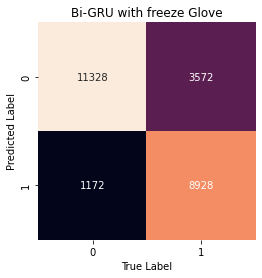

In [ ]:
GRUmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
filepath="weights-best_glove_freeze.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,
mode='max')
callbacks_list = [checkpoint]
GRUmodel.fit(x_train,y_train,batch_size=512,
          epochs=10,
          validation_data=(x_test,y_test),callbacks=callbacks_list)
predict=GRUmodel.predict(x_test,512)
p_r_score(y_test,predict)
show_confusion_matrix(y_test,predict,"Bi-GRU with freeze Glove")

In [ ]:
# load the gensim and load the word2vec trained on googlenews
import gensim
wv_from_text = gensim.models.KeyedVectors.load_word2vec_format("/content/drive/MyDrive/GoogleNews-vectors-negative300.bin", binary=True)

In [ ]:
# verified and print the vector for a word
wv_from_text.wv["woman"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


array([ 2.43164062e-01, -7.71484375e-02, -1.03027344e-01, -1.07421875e-01,
        1.18164062e-01, -1.07421875e-01, -1.14257812e-01,  2.56347656e-02,
        1.11816406e-01,  4.85839844e-02, -9.71679688e-02, -3.43750000e-01,
       -6.29882812e-02, -1.25000000e-01, -2.70996094e-02,  9.42382812e-02,
       -1.87500000e-01, -5.34667969e-02,  6.25000000e-02, -3.05175781e-02,
       -2.90527344e-02, -4.80957031e-02, -5.51757812e-02, -4.08203125e-01,
        1.01318359e-02, -2.32421875e-01, -1.70898438e-01,  2.63671875e-01,
        3.49609375e-01, -2.11914062e-01,  1.43554688e-01, -6.22558594e-03,
       -2.25585938e-01, -1.05468750e-01, -1.16210938e-01,  1.23046875e-01,
        3.06640625e-01, -4.88281250e-02, -9.57031250e-02,  1.99218750e-01,
       -1.57226562e-01, -2.80761719e-02,  1.58203125e-01, -2.42919922e-02,
        1.29882812e-01, -8.98437500e-02, -7.61718750e-02,  3.54003906e-02,
       -3.06396484e-02,  1.52343750e-01,  5.24902344e-02,  1.60980225e-03,
        5.56640625e-02,  

In [ ]:
# create the dict for word-vector
import keras
import tensorflow.keras
import numpy as np
word_index=keras.datasets.imdb.get_word_index()
num=0
voc=dict()
for k,v in  sorted(word_index.items(),key=lambda x :x[1])[:10000]:
  voc[k]=v
## Create "embedding_matrix" to index our vocabulary using the GloVe model 
num_tokens = len(voc) 
embedding_dim = 300 ## 100 dimensions
hits = 0 ## number of words that were found in the pretrained model
misses = 0 ## number of words that were missing in the pretrained model

# Prepare embedding matrix for our word list
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in voc.items():
    if word.lower() not in wv_from_text.wv:
      misses+=1
      continue
    embedding_vector = wv_from_text.wv[word.lower()]
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i-1] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

  # if num==10:
  #   break

Converted 9286 words (714 misses)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [ ]:
#3. fine-tuning the word2vec
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
embedding_layer = Embedding(num_tokens, embedding_dim,
                            embeddings_initializer= Constant(embedding_matrix), 
                            trainable=True,
)

In [ ]:
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(layers.GRU(20, return_sequences=True))(embedded_sequences)
x = layers.Bidirectional(layers.GRU(20))(x)
preds = layers.Dense(1, activation="sigmoid")(x)
GRUmodel = Model(int_sequences_input, preds)
GRUmodel.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_8 (Embedding)     (None, None, 300)         3000000   
                                                                 
 bidirectional_18 (Bidirecti  (None, None, 40)         38640     
 onal)                                                           
                                                                 
 bidirectional_19 (Bidirecti  (None, 40)               7440      
 onal)                                                           
                                                                 
 dense_9 (Dense)             (None, 1)                 41        
                                                                 
Total params: 3,046,121
Trainable params: 3,046,121
Non-tra

In [ ]:

GRUmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
filepath="weights-best_word2vec.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,
mode='max')
callbacks_list = [checkpoint]
GRUmodel.fit(x_train,y_train,batch_size=512,
          epochs=10,
          validation_data=(x_test,y_test),callbacks=callbacks_list)
predict=GRUmodel.predict(x_test,512)
p_r_score(y_test,predict)
show_confusion_matrix(y_test,predict,"bi-GRU with fine-tuning Word2vec")

Train...
Epoch 1/10
49/49 [==============================] - ETA: 0s - loss: 0.6535 - accuracy: 0.6092
Epoch 1: val_accuracy improved from -inf to 0.69016, saving model to weights-best_word2vec.hdf5
49/49 [==============================] - 48s 864ms/step - loss: 0.6535 - accuracy: 0.6092 - val_loss: 0.5753 - val_accuracy: 0.6902
Epoch 2/10
49/49 [==============================] - ETA: 0s - loss: 0.4606 - accuracy: 0.7828

In [ ]:
#4. freeze the word2vec 
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
embedding_layer = Embedding(num_tokens, embedding_dim,
                            embeddings_initializer= Constant(embedding_matrix), 
                            trainable=False,
)

In [ ]:
int_sequences_input = Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(layers.GRU(20, return_sequences=True))(embedded_sequences)
x = layers.Bidirectional(layers.GRU(20))(x)
preds = layers.Dense(1, activation="sigmoid")(x)
GRUmodel = Model(int_sequences_input, preds)
GRUmodel.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_7 (Embedding)     (None, None, 300)         3000000   
                                                                 
 bidirectional_16 (Bidirecti  (None, None, 40)         38640     
 onal)                                                           
                                                                 
 bidirectional_17 (Bidirecti  (None, 40)               7440      
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 1)                 41        
                                                                 
Total params: 3,046,121
Trainable params: 46,121
Non-traina

Train...
Epoch 1/10
49/49 [==============================] - ETA: 0s - loss: 0.6272 - accuracy: 0.6405
Epoch 1: val_accuracy improved from -inf to 0.65236, saving model to weights-freeze_word2vec.hdf5
49/49 [==============================] - 46s 793ms/step - loss: 0.6272 - accuracy: 0.6405 - val_loss: 0.6184 - val_accuracy: 0.6524
Epoch 2/10
49/49 [==============================] - ETA: 0s - loss: 0.5697 - accuracy: 0.7002
Epoch 2: val_accuracy improved from 0.65236 to 0.71732, saving model to weights-freeze_word2vec.hdf5
49/49 [==============================] - 37s 765ms/step - loss: 0.5697 - accuracy: 0.7002 - val_loss: 0.5496 - val_accuracy: 0.7173
Epoch 3/10
49/49 [==============================] - ETA: 0s - loss: 0.5378 - accuracy: 0.7258
Epoch 3: val_accuracy improved from 0.71732 to 0.73084, saving model to weights-freeze_word2vec.hdf5
49/49 [==============================] - 37s 761ms/step - loss: 0.5378 - accuracy: 0.7258 - val_loss: 0.5337 - val_accuracy: 0.7308
Epoch 4/10
49

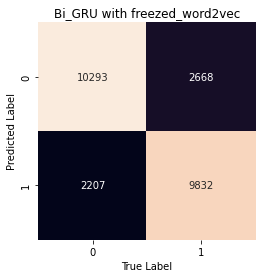

In [ ]:

GRUmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
filepath="weights-freeze_word2vec.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,
mode='max')
callbacks_list = [checkpoint]
GRUmodel.fit(x_train,y_train,batch_size=512,
          epochs=10,
          validation_data=(x_test,y_test),callbacks=callbacks_list)
predict=GRUmodel.predict(x_test,512)
p_r_score(y_test,predict)
show_confusion_matrix(y_test,predict,"Bi_GRU with freezed_word2vec")